# Background

**Context**

The data set belongs to a leading online E-commerce 
company. An online retail (E-commerce) company wants 
to know the customers who are going to churn, so 
accordingly, they can approach customers to offer some
promos.

Target:

0 : Not churned / Subscribed

1 : Churn / Unsubscribed / Left

**Problem**

The company doesn't know which customers are likely to churn and which aren't. Managers need a way to predict churning customers to be able to devise strategies to prevent churn or find out how to improve the business. It's important to be able to predict churn so that the company doesn't lose it's steady stream of income and userbase.

**Goals**

Accurately predict customers who are going to churn so that the company can approach them with promos to potentially stop them from churning

**Analytic Approach**

We'll build a classification machine learning model that the company can use to predict churning customers for offering them promos. Management will also be able to get insights from customers who are likely to churn predicted by the model.

**Metric Evaluation**

Type 1 Error : False Positive  
Consequence : Offered promo to a customer who isn't going to churn, directly costing the company the amount of money used to offer the promo.

Type 2 Error : False Negative  
Consequence : Customer churns and leaves, company loses *potential* profit.

Based on the consequences, we'll want to predict as many churning customers while avoiding false positives to maximize the amount of profit the model provides. In this case, the F1 score metric is the most suited as an evaluation metric because it is also more suited for imbalanced datasets than ROC AUC.

**Limitation**

This project will be focused on building an ML model to *predict* churn but it will not build an ML model that also devises promos to offer churning customers. 

Not enough data is available to be able to determine the appropriate promo for a churning customer and evaluate it's effectiveness.

# Data Understanding

Our dataset is composed of 11 columns with 3941 rows, each row representing a customer that has subscribed to the e-commerce company before.

## Features

1. Tenure: Tenure of a customer in the company
2. WarehouseToHome: Distance between the warehouse to the customer’s home.
3. NumberOfDeviceRegistered: Total number of deceives is registered on a particular customer.
4. PreferedOrderCat: Preferred order category of a  customer in the last month.
5. SatisfactionScore: Satisfactory score of a customer on service.
6. MaritalStatus: Marital status of a customer.
7. NumberOfAddress: Total number of added on a particular customer.
8. Complaint: Any complaint has been raised in the last month.
9. DaySinceLastOrder: Day since last order by customer.
10. CashbackAmount: Average cashback in last month.
11. Churn: Churn flag. 

Every column in this dataset except for Churn is the data of the customer the company has, and also recorded behavior such as Complain and DaySinceLastOrder.

Based on the sample size of the data and the amount of columns, we'll likely be able to make a relatively good-performing churn prediction model on this data alone.

In [283]:
import pandas as pd
import missingno as msn
from pycaret.classification import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from typing import Literal
from sklearn.preprocessing import FunctionTransformer

In [284]:
df = pd.read_csv(r'C:\Users\Elroy\Documents\pyth\cap3\data\raw\data_ecommerce_customer_churn.csv')
df

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1


In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


All the data is formatted correctly, and we'll need to encode PreferedOrderCat and MaritalStatus later as they are categorical columns based on the fact their datatype is an object.

CashbackAmount is a numerical column that is continuous, while other numerical columns are discrete. Complain and Churn have already been properly encoded as integers.

In [286]:
df['Churn'].value_counts()

0    3267
1     674
Name: Churn, dtype: int64

Here we find out our dataset is quite significantly imbalanced, so we'll need to handle that later.

<AxesSubplot: >

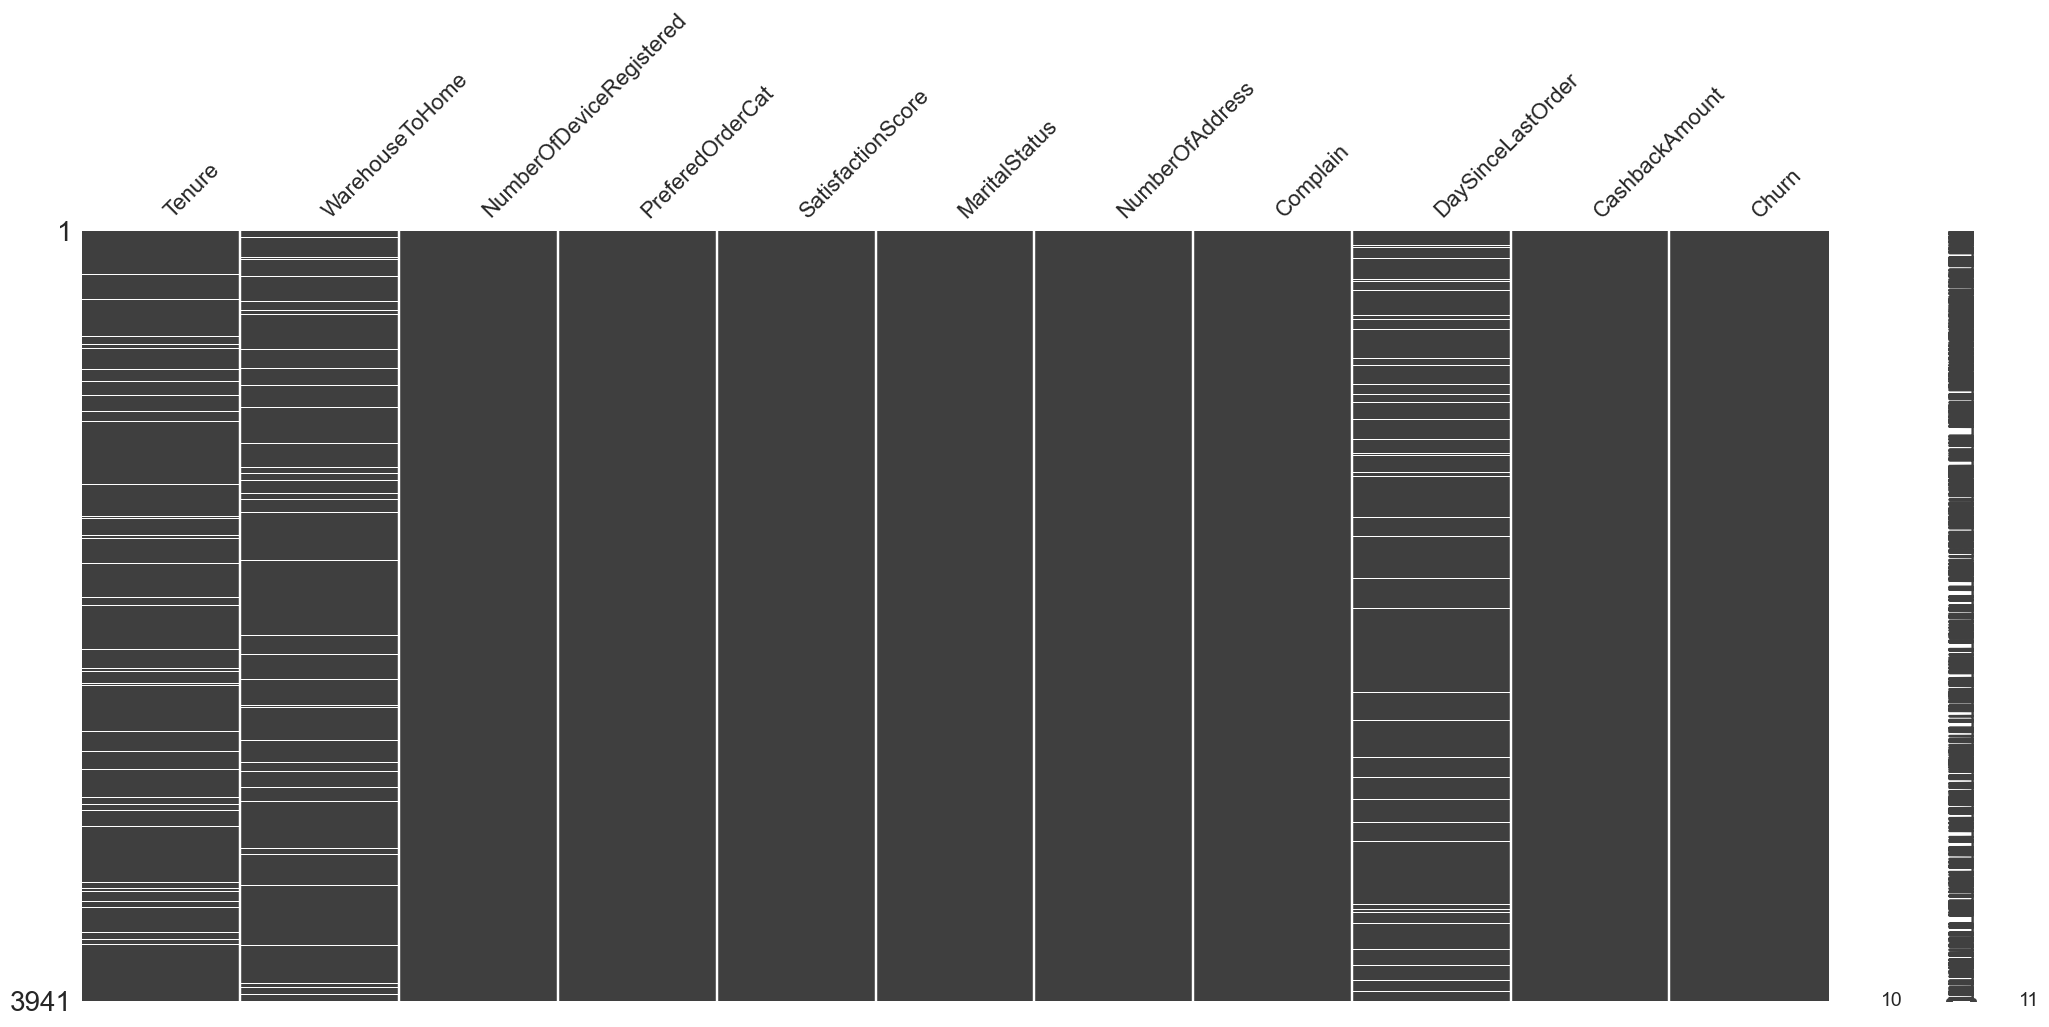

In [287]:
msn.matrix(df)

<AxesSubplot: >

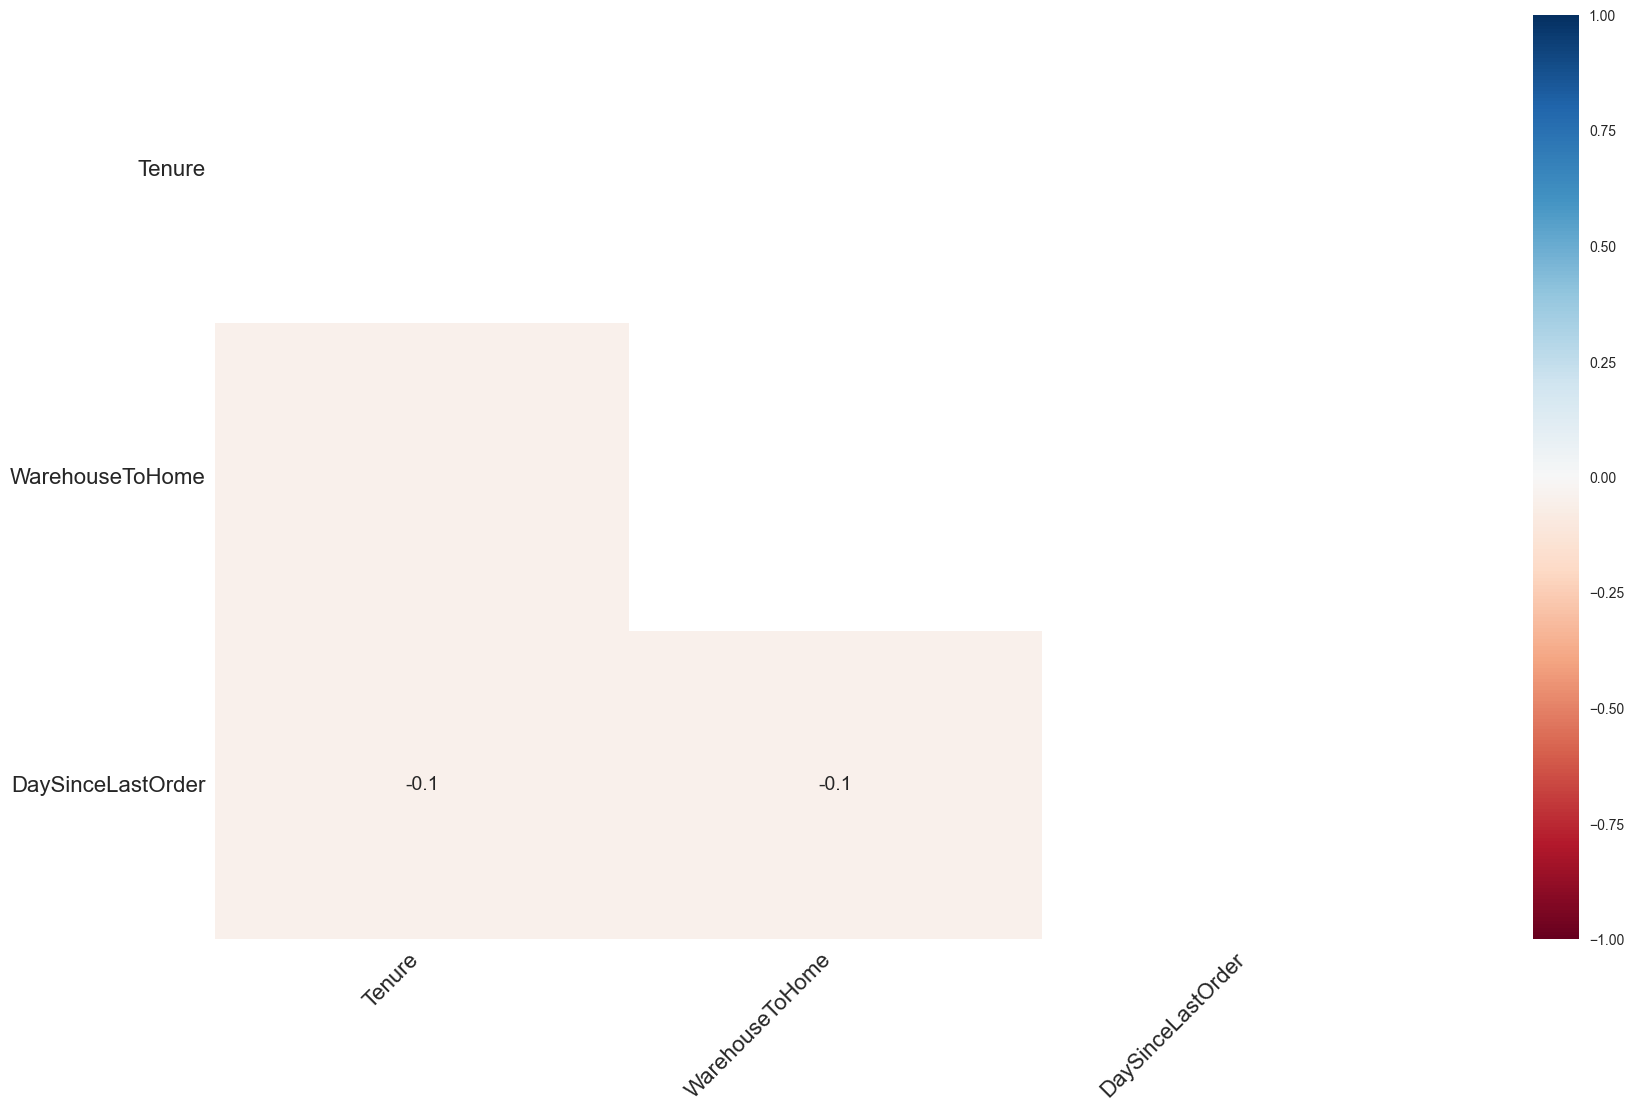

In [288]:
msn.heatmap(df)

In [289]:
def calculate_empty_to_non_empty_ratio(column):
    empty_count = column.isna().sum()
    non_empty_count = column.count()
    if non_empty_count == 0:
        return 0
    return (empty_count / (empty_count + non_empty_count)) * 100

# Calculate the percentage for each column
percentage_empty_to_non_empty = df.apply(calculate_empty_to_non_empty_ratio)

# Create a new DataFrame to store the results
result_df = pd.DataFrame({'Percentage Empty to Non-Empty': percentage_empty_to_non_empty})
print(result_df)

                          Percentage Empty to Non-Empty
Tenure                                         4.922608
WarehouseToHome                                4.288252
NumberOfDeviceRegistered                       0.000000
PreferedOrderCat                               0.000000
SatisfactionScore                              0.000000
MaritalStatus                                  0.000000
NumberOfAddress                                0.000000
Complain                                       0.000000
DaySinceLastOrder                              5.404720
CashbackAmount                                 0.000000
Churn                                          0.000000


The dataset has a significant amount of missing values that add up to more than 5%, so we'll need to fill them in. 

It's also noteworthy that the missing values don't seem to have any correlations or patterns and is completely random.

In [290]:
df.duplicated().sum()

671

671 duplicates, we'll drop them later in data cleaning.

In [291]:
listItem = []
for col in df.columns:
    unique_values = df[col].unique()
    unique_values_str = ', '.join(map(str, unique_values))
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum() / len(df[col])) * 100, 2),
                    df[col].nunique(), unique_values_str])

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'allUniqueValues'],
                      data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,allUniqueValues
0,Tenure,float64,194,4.92,36,"15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0, ..."
1,WarehouseToHome,float64,169,4.29,33,"29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0,..."
2,NumberOfDeviceRegistered,int64,0,0.00,6,"4, 3, 6, 2, 5, 1"
3,PreferedOrderCat,object,0,0.00,6,"Laptop & Accessory, Mobile, Fashion, Others, M..."
4,SatisfactionScore,int64,0,0.00,5,"3, 1, 4, 2, 5"
5,MaritalStatus,object,0,0.00,3,"Single, Married, Divorced"
6,NumberOfAddress,int64,0,0.00,14,"2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21"
7,Complain,int64,0,0.00,2,"0, 1"
8,DaySinceLastOrder,float64,213,5.40,22,"7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0, ..."
9,CashbackAmount,float64,0,0.00,2335,"143.32, 129.29, 168.54, 230.27, 322.17, 152.81..."


In [292]:
df['PreferedOrderCat'].unique()

array(['Laptop & Accessory', 'Mobile', 'Fashion', 'Others',
       'Mobile Phone', 'Grocery'], dtype=object)

Here, we see that all the columns seem to have correct inputs except for PreferedOrderCat which has 'Mobile' and 'Mobile Phone', we'll change 'Mobile' into 'Mobile Phone' so it's correct.

We'll also find that the CashbackAmount has high cardinality and we may need to bin/discretize it later for preprocessing.

## Data Preparation


In [293]:
df.drop_duplicates(keep='first',inplace=True)
df

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3933,25.0,15.0,5,Fashion,4,Married,7,0,8.0,249.90,0
3935,26.0,7.0,4,Grocery,1,Married,4,0,9.0,295.99,0
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0


In [294]:
percentage_empty_to_non_empty = df.apply(calculate_empty_to_non_empty_ratio)

# Create a new DataFrame to store the results
result_df = pd.DataFrame({'Percentage Empty to Non-Empty': percentage_empty_to_non_empty})
print(result_df)

                          Percentage Empty to Non-Empty
Tenure                                         4.892966
WarehouseToHome                                4.128440
NumberOfDeviceRegistered                       0.000000
PreferedOrderCat                               0.000000
SatisfactionScore                              0.000000
MaritalStatus                                  0.000000
NumberOfAddress                                0.000000
Complain                                       0.000000
DaySinceLastOrder                              5.535168
CashbackAmount                                 0.000000
Churn                                          0.000000


Duplicates dropped and still a large amount of missing values.

In [295]:
df.describe()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3110.000000,3135.000000,3270.000000,3270.000000,3270.000000,3270.000000,3089.000000,3270.000000,3270.000000
mean,10.190354,15.510367,3.676453,3.020795,4.222936,0.281651,4.545484,177.417670,0.163303
std,8.650821,8.568382,1.017390,1.395113,2.623195,0.449873,3.696022,49.310647,0.369698
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,145.892500,0.000000
50%,9.000000,13.000000,4.000000,3.000000,3.000000,0.000000,3.000000,163.885000,0.000000
75%,16.000000,20.000000,4.000000,4.000000,6.000000,1.000000,7.000000,197.137500,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


In [296]:
df.dropna().describe()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,2794.000000,2794.000000,2794.000000,2794.000000,2794.000000,2794.000000,2794.000000,2794.000000,2794.000000
mean,10.284896,15.560129,3.698998,3.025412,4.283107,0.283107,4.784896,180.412058,0.147101
std,8.665384,8.636022,1.023508,1.395250,2.623741,0.450588,3.720533,48.885374,0.354270
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,148.485000,0.000000
50%,9.000000,13.000000,4.000000,3.000000,3.000000,0.000000,4.000000,165.360000,0.000000
75%,16.000000,21.000000,4.000000,4.000000,6.000000,1.000000,8.000000,192.925000,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


Checking the data with and without missing values, there doesn't seem to be significant differences in the statistics between them so we can just use a simple imputer with the median to fill in the missing values and won't have to worry about changing any patterns.

In [297]:
from sklearn.impute import SimpleImputer

columns_to_impute = ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']  # List of columns to impute

for column in columns_to_impute:
    imputer = SimpleImputer(strategy='median')
    imputer.fit(df[column].values.reshape(-1, 1))
    df[column] = imputer.transform(df[column].values.reshape(-1, 1))

In [298]:
df.replace(to_replace='Mobile',value='Mobile Phone',inplace=True)

In [299]:
df['PreferedOrderCat'].value_counts() / len(df) * 100

Laptop & Accessory    37.094801
Mobile Phone          36.177370
Fashion               14.801223
Grocery                7.370031
Others                 4.556575
Name: PreferedOrderCat, dtype: float64

We've now filled in the missing values in the data and also fixed the error in the PreferedOrderCat column, we can now move on to Exploratory Data Analysis

## Exploratory Data Analysis

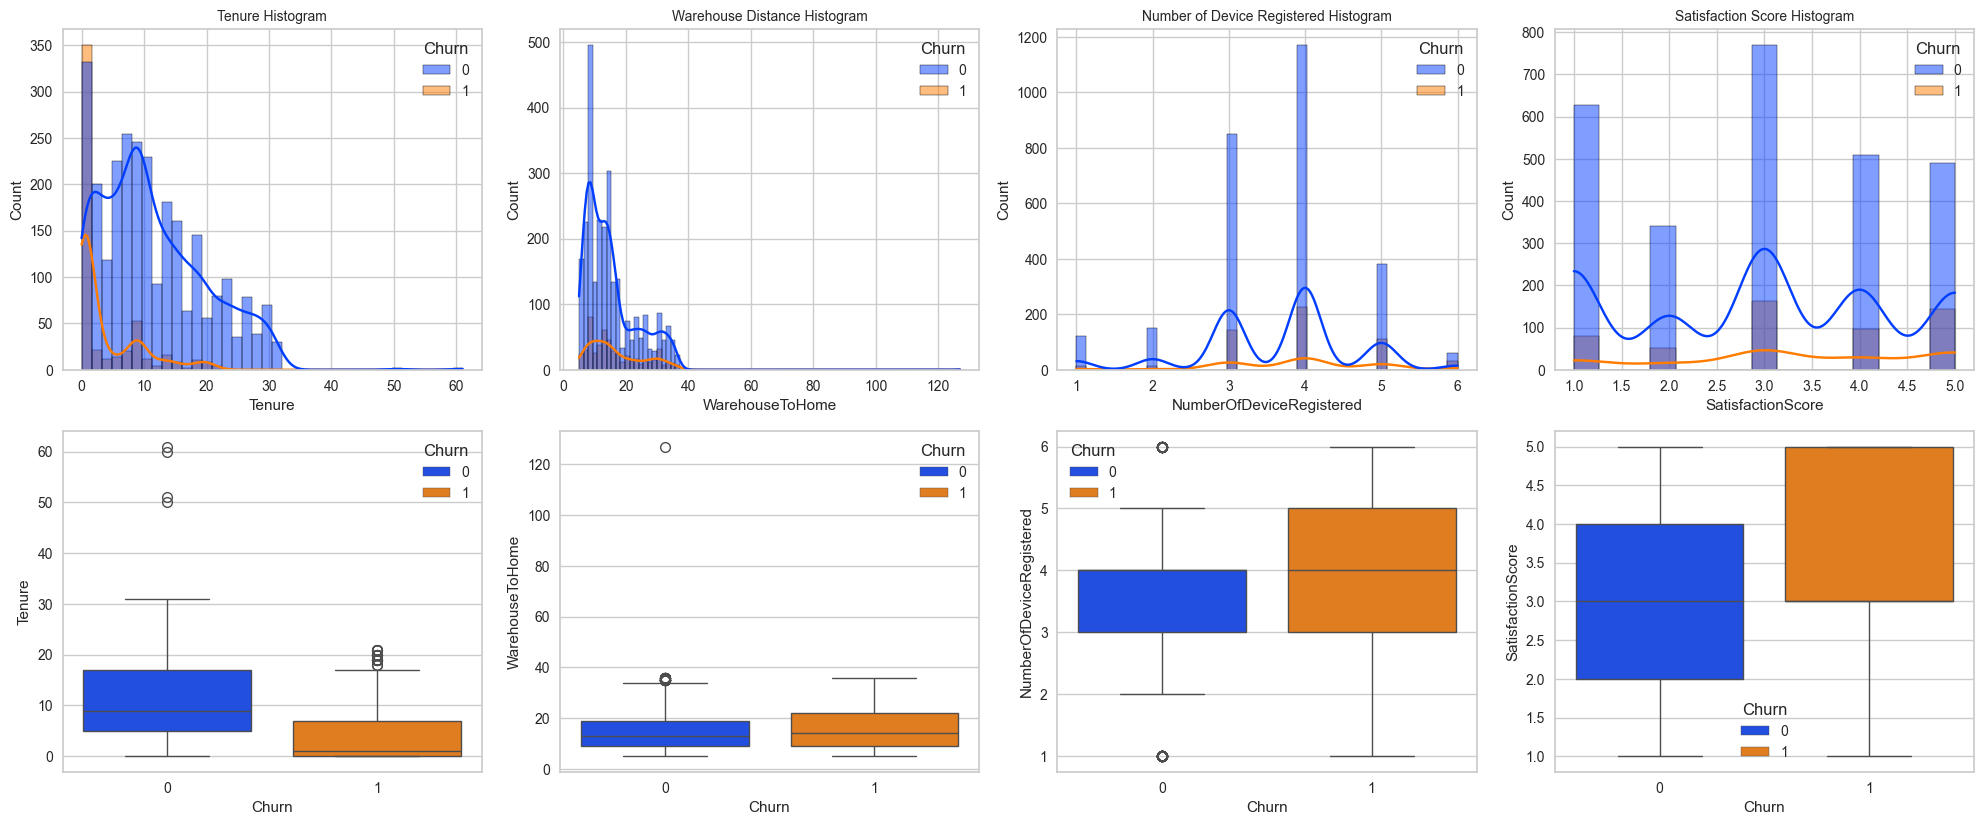

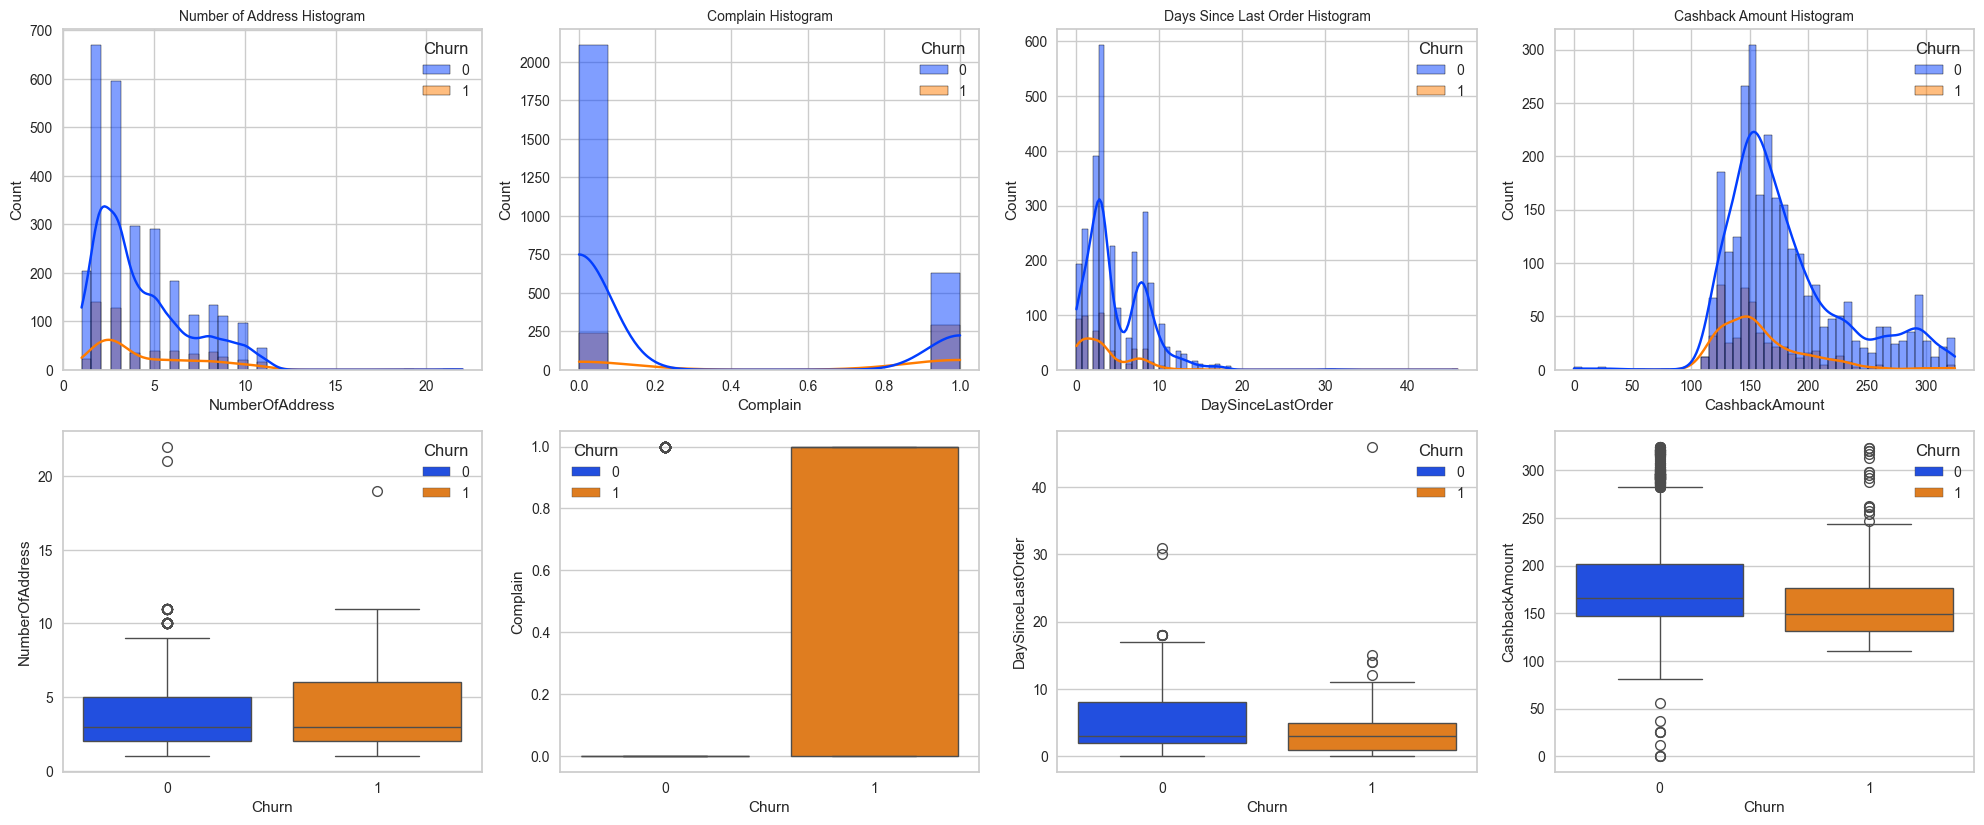

In [300]:
sns.set_palette('bright')

plt.figure(figsize=(20,12))

plt.subplot(341)
sns.histplot(data=df,x='Tenure',hue='Churn',kde=True)
plt.title('Tenure Histogram',fontsize=10)

plt.subplot(342)
sns.histplot(data=df,x='WarehouseToHome',hue='Churn',kde=True)
plt.title('Warehouse Distance Histogram',fontsize=10)

plt.subplot(343)
sns.histplot(data=df,x='NumberOfDeviceRegistered',hue='Churn',kde=True)
plt.title('Number of Device Registered Histogram',fontsize=10)

plt.subplot(344)
sns.histplot(data=df,x='SatisfactionScore',hue='Churn',kde=True)
plt.title('Satisfaction Score Histogram',fontsize=10)

plt.subplot(345)
sns.boxplot(data=df,y='Tenure', x='Churn',hue='Churn')

plt.subplot(346)
sns.boxplot(data=df,y='WarehouseToHome', x='Churn',hue='Churn')

plt.subplot(347)
sns.boxplot(data=df,y='NumberOfDeviceRegistered', x='Churn',hue='Churn')

plt.subplot(348)
sns.boxplot(data=df,y='SatisfactionScore', x='Churn',hue='Churn')

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 12))

plt.subplot(341)
sns.histplot(data=df, x='NumberOfAddress', hue='Churn', kde=True)
plt.title('Number of Address Histogram', fontsize=10)

plt.subplot(342)
sns.histplot(data=df, x='Complain', hue='Churn', kde=True)
plt.title('Complain Histogram', fontsize=10)

plt.subplot(343)
sns.histplot(data=df, x='DaySinceLastOrder', hue='Churn', kde=True)
plt.title('Days Since Last Order Histogram', fontsize=10)

plt.subplot(344)
sns.histplot(data=df, x='CashbackAmount', hue='Churn', kde=True)
plt.title('Cashback Amount Histogram', fontsize=10)

plt.subplot(345)
sns.boxplot(data=df, y='NumberOfAddress', x='Churn', hue='Churn')

plt.subplot(346)
sns.boxplot(data=df, y='Complain', x='Churn', hue='Churn')

plt.subplot(347)
sns.boxplot(data=df, y='DaySinceLastOrder', x='Churn', hue='Churn')

plt.subplot(348)
sns.boxplot(data=df, y='CashbackAmount', x='Churn', hue='Churn')

plt.tight_layout()
plt.show()

We'll find that there is a clear link between Complain and Churn, and Tenure of churned users are shorter which is expected, as longer tenures indiciate more satisfaction.

An unexpected insight is that satisfaction score spread in churned users is very spread out and not skewed negatively, contrary to what one would expect.

CashbackAmount is also lower in churned users, indicating that promos do work in retaining users and preventing churn.

The dataset also has some significant outliers, which we can later remove or replace in a pipeline.

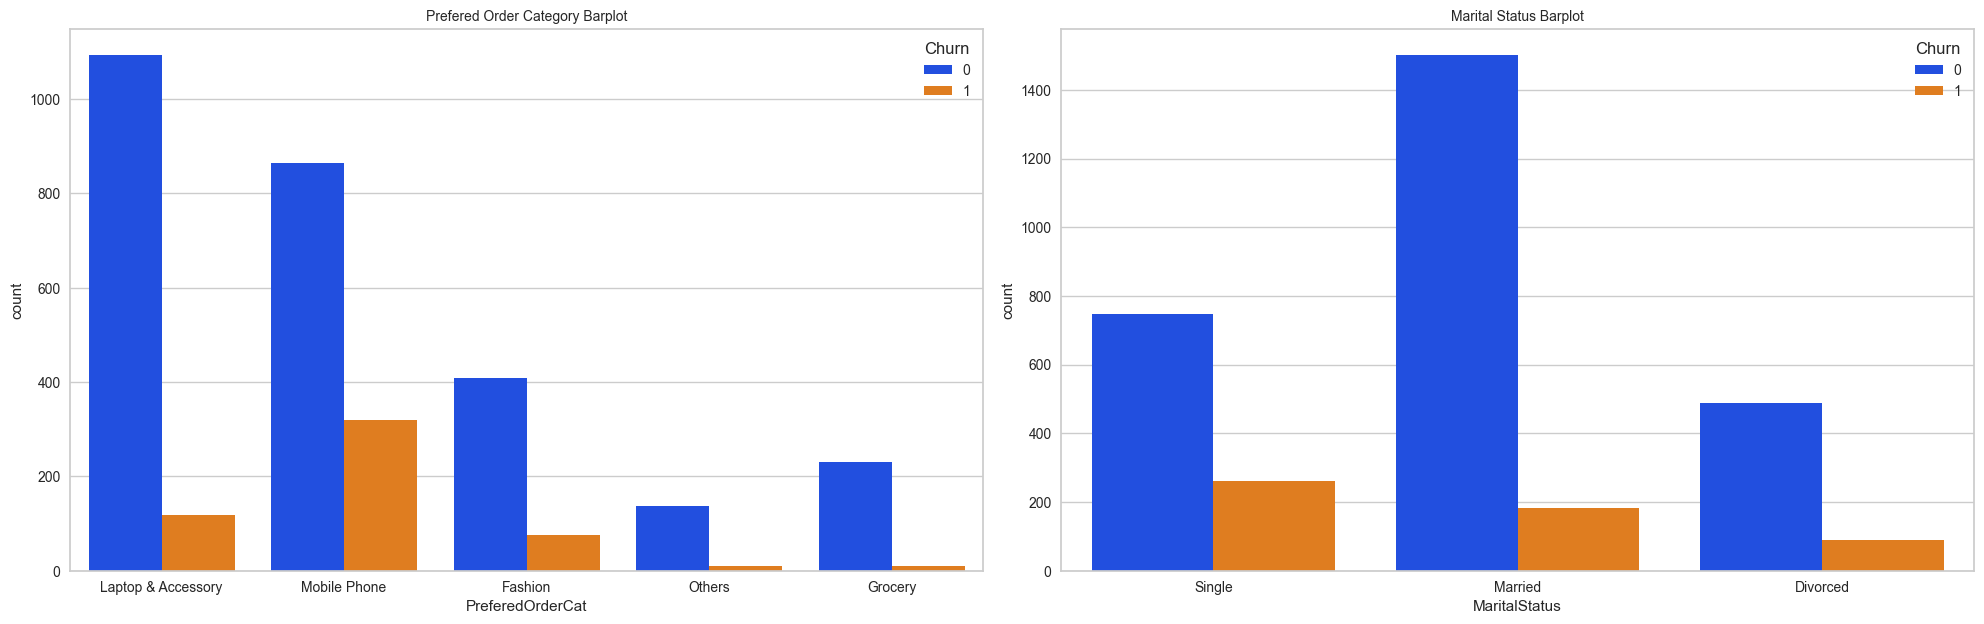

In [301]:
sns.set_palette('bright')

plt.figure(figsize=(20,12))

plt.subplot(221)
sns.countplot(data=df,x='PreferedOrderCat',hue='Churn')
plt.title('Prefered Order Category Barplot',fontsize=10)

plt.subplot(222)
sns.countplot(data=df,x='MaritalStatus',hue='Churn')
plt.title('Marital Status Barplot',fontsize=10)

plt.tight_layout()

plt.show()

From the categorical columns, we see that the churn rate does appear to be different between the different values so they'll be useful for the classification model as features.

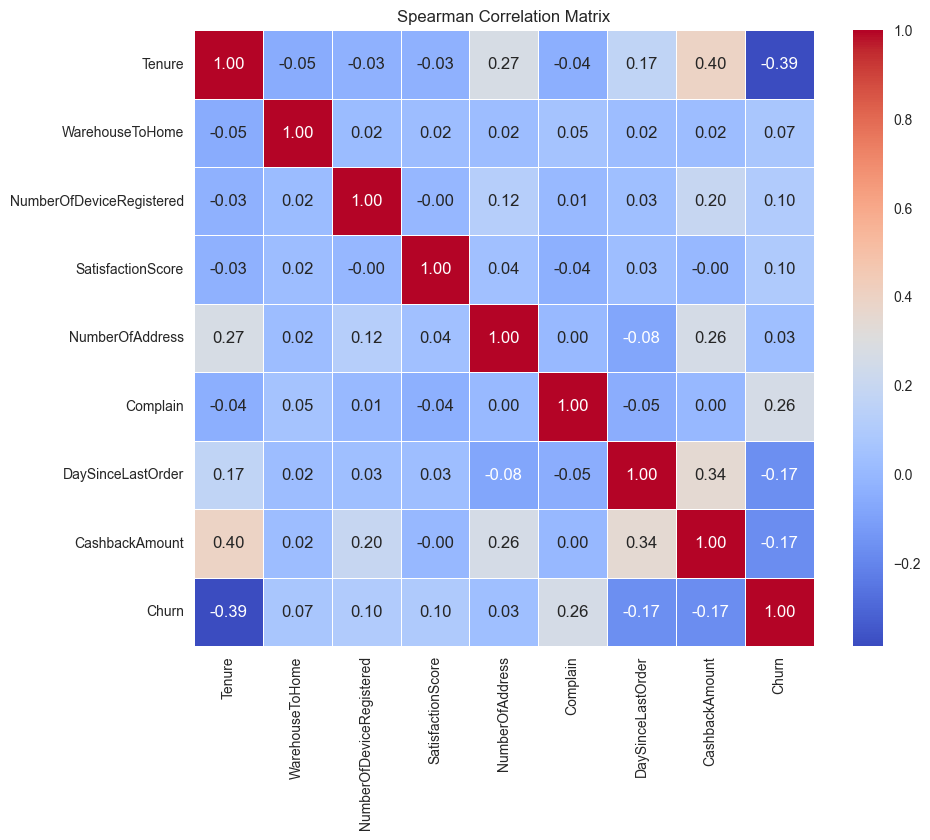

In [302]:
numerical_columns = df.select_dtypes(include=['number'])

correlation_matrix = numerical_columns.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation Matrix")
plt.show()

Looking through the correlation chart, we find that the main feature that indicates churning the most is Complain, and that Tenure, CashbackAmount and DaySinceLastOrder are correlated with non-churning customers.

Based on that information, it's likely that by addressing these complaints the e-commerce business could also lower it's churn rate.

In [303]:
df['Churn'].value_counts() / len(df) * 100

0    83.669725
1    16.330275
Name: Churn, dtype: float64

The dataset's imbalance is also still relatively similar to before cleaning.

## Data Preprocessing

Now, we'll split the data into the training and test sets, along with setting up the custom pipeline for modelling.

In [304]:
from sklearn.model_selection import train_test_split

df_seen, df_unseen = train_test_split(df, stratify=df['Churn'], test_size=0.1, random_state=42)

Small test size to maximize amount of training data for the model, as our dataset isn't that large.

In [305]:
transformers = ColumnTransformer(
    transformers=[
        ("imputation", SimpleImputer(
            missing_values=np.nan, strategy="median", fill_value='other'), 
            ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']),
        ("onehot", OneHotEncoder(), ['MaritalStatus', 'PreferedOrderCat'])
    ],
    remainder="passthrough", 
    verbose_feature_names_out=False).set_output(transform='pandas')

preprocessor = make_pipeline(
    transformers
)

# Modeling

With the data now ready to be used for modelling, PyCaret will be used to compare and setup experiments to find out the best model and evaluate it's efficacy.

In [306]:
base = setup(
    # Global config
    experiment_name='Churn Classification',
    data=df_seen, 
    target='Churn', 
    train_size=0.8,
    verbose=False,

    # Data preprocessing config
    preprocess=False,
    session_id=42, 
    custom_pipeline=preprocessor,
    custom_pipeline_position=-1,

    # Model selection config
    fold=10,
    fold_shuffle=False,
    fold_strategy='stratifiedkfold'
        
)

# Show the pipeline
get_config('pipeline')

Pipeline(memory=FastMemory(location=C:\Users\Elroy\AppData\Local\Temp\joblib),
         steps=[('custom_step',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=Pipeline(memory=None,
                                                         steps=[('columntransformer',
                                                                 ColumnTransformer(n_jobs=None,
                                                                                   remainder='passthrough',
                                                                                   sparse_threshold=0.3,
                                                                                   transformer_weights=None,
                                                                                   transformers=[('imputation',
                                                                                                  SimpleImputer(ad...
                                                                                                                strategy='median',
                                                                                                                verbose='deprecated'),
                                                                                                  ['Tenure',
                                                                                                   'WarehouseToHome',
                                                                                                   'DaySinceLastOrder']),
                                                                                                 ('onehot',
                                                                                                  OneHotEncoder(cols=None,
                                                                                                                drop_invariant=False,
                                                                                                                handle_missing='value',
                                                                                                                handle_unknown='value',
                                                                                                                return_df=True,
                                                                                                                use_cat_names=False,
                                                                                                                verbose=0),
                                                                                                  ['MaritalStatus',
                                                                                                   'PreferedOrderCat'])],
                                                                                   verbose=False,
                                                                                   verbose_feature_names_out=False))],
                                                         verbose=False)))],
         verbose=False)

In [307]:
get_config('X_train_transformed')

,Tenure,WarehouseToHome,DaySinceLastOrder,MaritalStatus_1,MaritalStatus_2,MaritalStatus_3,PreferedOrderCat_1,PreferedOrderCat_2,PreferedOrderCat_3,PreferedOrderCat_4,PreferedOrderCat_5,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,CashbackAmount
2423,1.0,16.0,1.0,1,0,0,1,0,0,0,0,5,4,3,0,151.940002
1066,11.0,26.0,3.0,1,0,0,0,1,0,0,0,4,3,5,0,182.679993
1191,1.0,36.0,9.0,0,1,0,0,1,0,0,0,5,3,3,0,170.080002
2762,31.0,36.0,1.0,1,0,0,0,0,1,0,0,5,1,5,0,266.179993
2405,5.0,14.0,3.0,0,0,1,0,0,0,1,0,5,3,3,0,214.429993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,16.0,15.0,1.0,0,1,0,1,0,0,0,0,4,3,6,0,164.679993
560,1.0,7.0,8.0,0,0,1,0,0,0,1,0,4,5,3,0,199.119995
98,0.0,35.0,8.0,0,1,0,0,1,0,0,0,4,3,2,0,145.080002
1178,1.0,31.0,1.0,1,0,0,1,0,0,0,0,4,4,3,1,149.080002


Pipeline has correctly preprocessed dataset.

Then we'll benchmark the available models in PyCaret and also experiment with different setups.

In [308]:
folds5 = setup(
# Experiment with less folds

    # Global config
    experiment_name='Churn Classification',
    data=df_seen, 
    target='Churn', 
    train_size=0.8,
    verbose=False,

    # Data preprocessing config
    preprocess=False,
    session_id=42, 
    custom_pipeline=preprocessor,
    custom_pipeline_position=-1,

    # Model selection config
    fold=5,
    fold_shuffle=False,
    fold_strategy='stratifiedkfold'
        
)

folds15 = setup(
# Experiment with more folds

    # Global config
    experiment_name='Churn Classification',
    data=df_seen, 
    target='Churn', 
    train_size=0.8,
    verbose=False,

    # Data preprocessing config
    preprocess=False,
    session_id=42, 
    custom_pipeline=preprocessor,
    custom_pipeline_position=-1,

    # Model selection config
    fold=15,
    fold_shuffle=False,
    fold_strategy='stratifiedkfold'
        
)

nostrat = setup(
# Experiment with different fold strategy

    # Global config
    experiment_name='Churn Classification',
    data=df_seen, 
    target='Churn', 
    train_size=0.8,
    verbose=False,

    # Data preprocessing config
    preprocess=False,
    session_id=42, 
    custom_pipeline=preprocessor,
    custom_pipeline_position=-1,

    # Model selection config
    fold=10,
    fold_shuffle=False,
    fold_strategy='kfold'
)


Here, we've setup different experiments which include
* Amount of folds
* Imbalance fixing methods 
* Fold strategy

However to save time, we'll only compare the top 3 performing models (F1-score) from the base setup across the experiments.

In [309]:
models_base = base.compare_models(sort='F1')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:56:44
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9070,0.9359,0.6337,0.7585,0.6896,0.6355,0.6396,0.1390
rf,Random Forest Classifier,0.9065,0.9326,0.5920,0.7886,0.6745,0.6213,0.6311,0.1450
gbc,Gradient Boosting Classifier,0.9031,0.9198,0.5818,0.7707,0.6621,0.6070,0.6157,0.1540
dt,Decision Tree Classifier,0.8764,0.7881,0.6570,0.6150,0.6345,0.5603,0.5612,0.0360
et,Extra Trees Classifier,0.8963,0.9221,0.5271,0.7764,0.6267,0.5688,0.5840,0.1240
ada,Ada Boost Classifier,0.8862,0.8918,0.5401,0.6966,0.6072,0.5421,0.5487,0.0750
lr,Logistic Regression,0.8781,0.8751,0.4516,0.6952,0.5461,0.4796,0.4952,0.7480
lda,Linear Discriminant Analysis,0.8777,0.8663,0.4362,0.7046,0.5367,0.4710,0.4901,0.0250
nb,Naive Bayes,0.7523,0.8030,0.7219,0.3703,0.4887,0.3476,0.3817,0.0320
knn,K Neighbors Classifier,0.8521,0.7804,0.3445,0.5828,0.4290,0.3513,0.3691,0.0430


Top 3 models in terms of F1-score are LightGBM, Random Forest and Gradient Booster, so they'll be the ones we benchmark across the setups.

In [310]:
benchmark_model=['lightgbm','rf','gbc']

print("Base Setup")
models_base = base.compare_models(include=benchmark_model,sort='F1')
print("5 Folds Setup")
models_folds5 = folds5.compare_models(include=benchmark_model,sort='F1')
print("15 Folds Setup")
models_folds15 = folds15.compare_models(include=benchmark_model,sort='F1')
print("KFold Setup")
models_nostrat = nostrat.compare_models(include=benchmark_model,sort='F1')

Base Setup


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:57:04
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9070,0.9359,0.6337,0.7585,0.6896,0.6355,0.6396,0.1730
rf,Random Forest Classifier,0.9065,0.9326,0.5920,0.7886,0.6745,0.6213,0.6311,0.1470
gbc,Gradient Boosting Classifier,0.9031,0.9198,0.5818,0.7707,0.6621,0.6070,0.6157,0.1380


5 Folds Setup


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9048,0.9331,0.6312,0.7527,0.6846,0.6292,0.6338,0.1180
rf,Random Forest Classifier,0.9074,0.9298,0.5740,0.8074,0.6695,0.6175,0.6305,0.1500
gbc,Gradient Boosting Classifier,0.9010,0.9157,0.5766,0.7630,0.6547,0.5984,0.6076,0.1220


15 Folds Setup


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9142,0.9415,0.6521,0.7900,0.7131,0.6632,0.6683,0.1427
rf,Random Forest Classifier,0.9070,0.9345,0.5873,0.7981,0.6727,0.6202,0.6323,0.1280
gbc,Gradient Boosting Classifier,0.9010,0.9205,0.5769,0.7624,0.6544,0.5982,0.6074,0.0947


KFold Setup


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9078,0.9378,0.6523,0.7555,0.6963,0.6426,0.6475,0.1420
rf,Random Forest Classifier,0.9095,0.9337,0.5970,0.8064,0.6828,0.6317,0.6435,0.1780
gbc,Gradient Boosting Classifier,0.9036,0.9199,0.5840,0.7742,0.6630,0.6084,0.6184,0.1330


As seen from the tables above, the base experiment setup seems to the best for the F1 score of the models, so we'll take the best performing model which is LightGBM and tune it using the base experiment setup settings.

Random search will be used instead of grid search due to the demanded memory from grid search being high.

In [311]:
lgbm = create_model('lightgbm', verbose=False, objective='binary',is_unbalance=True)

tuned_lgbm = base.tune_model(
    estimator=lgbm, 
    optimize='f1', 
    n_iter=100, 
    return_train_score=False,
    search_library='scikit-learn',
    search_algorithm='random',
    choose_better=True
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9068,0.9369,0.8462,0.6735,0.7500,0.6936,0.7004
1,0.8898,0.9227,0.7949,0.6327,0.7045,0.6379,0.6442
2,0.8941,0.9283,0.7436,0.6591,0.6988,0.6348,0.6365
3,0.8983,0.9418,0.7436,0.6744,0.7073,0.6460,0.6471
4,0.8979,0.9430,0.8421,0.6400,0.7273,0.6659,0.6754
5,0.8809,0.9475,0.7895,0.6000,0.6818,0.6102,0.6189
6,0.8809,0.9100,0.7632,0.6042,0.6744,0.6027,0.6089
7,0.9106,0.9507,0.7895,0.6977,0.7407,0.6870,0.6889
8,0.9021,0.9301,0.7895,0.6667,0.7229,0.6640,0.6675


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


However, the original model is better than the tuned model, so we'll proceed with it.

In [312]:
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

With evaluate model we can gain some valuable insights from our LightGBM model.

1. Learning Curve

The chart shows how our model is far from parity between training and cross validation, which would be helped by more training instances which means more data. The gap between them also shows our model is currently overfitting to the training set.

2. Precision Recall Curve

The curve shows us our model has a good balance between precision and recall, which is what we want for predicting churn while not overly prioritizing false positives.

3. Class Report

In the classification report, we'll see that the model performs better at predicting non churning customers than churning customers, however the F1-score of churning customers is still an acceptable 0.7, but can definitely use improvement.

4. Feature Importance

We'll find in this chart that CashbackAmount affects the predictions of the model the most which makes sense, and the categorical values still have some impact albeit significantly smaller. This means that keeping the columns in the pipeline was not an incorrect decision.



So, based on the evaluation, this model is suitable enough for the task of predicting churn. 

The final model is a LightGBM model which combines typically decision trees to form a strong prediction model. It's limited to only predicting churn and not also the step of offering promos to customers.

In [313]:
_ = predict_model(tuned_lgbm)

Running the data on the validation set, we find the F1 score is still acceptable, and is not extremely different from the training set. We can now finalize the model after confirming it is not extremely overfitting or different.

In [314]:
final_lgbm = finalize_model(tuned_lgbm)

In [315]:
predict_model(final_lgbm,data=df_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9052,0.9696,0.8679,0.6571,0.7480,0.6910,0.7011


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn,prediction_label,prediction_score
906,4.0,29.0,5,Laptop & Accessory,3,Divorced,4,1,1.0,188.800003,1,1,0.9363
2791,24.0,16.0,4,Mobile Phone,1,Married,6,0,1.0,148.800003,0,0,0.9938
932,9.0,14.0,3,Laptop & Accessory,1,Married,5,0,7.0,150.789993,0,0,0.9667
1887,9.0,26.0,3,Laptop & Accessory,3,Single,1,0,2.0,122.720001,0,0,0.9537
582,5.0,18.0,4,Mobile Phone,1,Married,5,1,3.0,148.559998,0,0,0.9567
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750,7.0,32.0,5,Laptop & Accessory,4,Single,3,0,3.0,168.199997,0,0,0.7848
485,10.0,6.0,4,Laptop & Accessory,3,Married,2,0,7.0,159.929993,0,0,0.9960
2015,13.0,13.0,3,Mobile Phone,4,Married,4,0,3.0,123.870003,0,0,0.9886
2863,13.0,9.0,5,Laptop & Accessory,2,Divorced,10,0,5.0,177.039993,0,0,0.9504


Running our finalized model through the unseen test data, we find that it still performs at the same level with the training set. However, the scores are still different, which means no data leakage occured. We can move onto quantifying the effect of the algorithm on the business.

Making an assumption that an average customer's CLV of this business is 500 due to the technology focus of the company meaning higher profits, we'll then take the median cashback amount as the cost for offering promos to a customer that is predicted to be churning. Using this, we can get a very rough and optimistic estimation of how much extra profit the algorithm makes than with no ML model.

In [316]:
df['CashbackAmount'].median()

163.885

In [317]:
def calculate_profit(y, y_pred):
    tp = np.where((y_pred==1) & (y==1), (500-163), 0)
    fp = np.where((y_pred==1) & (y==0), (-163), 0)
    return np.sum([tp,fp])

# add metric to PyCare
add_metric('profit', 'Profit', calculate_profit)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                   make_scorer(calculate_profit)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit, dtype: object

In [318]:
unseen_predictions = predict_model(final_lgbm, data=df_unseen, raw_score=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Light Gradient Boosting Machine,0.9052,0.9696,0.8679,0.6571,0.7480,0.6910,0.7011,11590


In [319]:
df_unseen.shape[0]

327

Here we can see that in a best case scenario, our model adds $11590 extra profit to the company by preventing customers from churning. 

From a dataset of 327 people, that is a potential extra $35 per customer. 

Model will be saved in pickle.

In [320]:
import pickle

with open(r'C:\Users\Elroy\Documents\pyth\cap3\model\final_model.pkl', 'wb') as file : 
    pickle.dump(final_lgbm, file)

# Conclusion

The e-commerce company how has a machine learning algorithm to predict churning customers, although the model is still limited to only predicting.

Ideally, the model would also be able to offer promos by itself, however not enough data is present to be able to accurately capture what promo is suitable for a customer.

With the model, the business can earn up to an extra $35 from every customer, however this is a very optimistic figure due to a lack of data available to draw on and use as figures. 

## Reccomendation

More data overall would significantly improve the potential of the model. Currently, the model needs more data so that it doesn't overfit into the training set and also to lessen the potential effects of an imbalance dataset within smaller samples like the test set.

Additional customer data like the average amount of money spent or deliveries made would enable further development of the model into being able to offers promos by itself, as it would be able to find optimal trade-offs between promos and profits.